# The Capacitated Vehicle Routing Problem

This notebook look at solving the CVRP using the **exact methods implemented in Gurobi**

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take routing software years to find the optimal solution... 

In [21]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import seaborn as sns
sns.set()

## Helper functions

In [5]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    #plt.scatter(x_coords[1:], y_coords[1:], c='b')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

In [7]:
def problem_instance(n_patients, vehicle_capacity, random_state=None):
    '''
    Create an instance of the CVRP in the formulation
    of a MIP.
    
    Parameters:
    ------
    n_patient: int
    vehicle_capacity: int
    random_state: int, optional (default=None)
    
    Returns:
    -----
        dict, keys = N, V, A, c, Q, q
    '''
    rand_gen = RandomState(seed=random_state)
    
    #n_patients = 1 so we include the depot
    x_coords = rand_gen.random(size=n_patients+1) * 200
    y_coords = rand_gen.random(size=n_patients+1) * 100
    
    N = np.arange(1, n_patients+1)
    V = np.arange(0, n_patients+1)
    A = [(i, j) for i in V for j in V if i != j]
    c = {(i, j): np.hypot(x_coords[i]-x_coords[j], y_coords[i]-y_coords[j]) 
     for i, j in A}
    Q = vehicle_capacity
    q = {i: 1 for i in N}
    return {'x_coords':x_coords, 'y_coords':y_coords, 
            'N':N, 'V':V, 'A':A, 'c':c, 'Q':Q, 'q':q}

In [8]:
def optimisation_model(instance):
    '''
    Create and return an istance of a gurobi optimisation
    model for solving the CVRP.
    
    Parameters:
    -------
    instance: dict
        problem instance for the CVRP
    '''
    mdl = Model('dialysis_transport')
    
    N = instance['N']
    V = instance['V']
    A = instance['A']
    c = instance['c']
    Q = instance['Q']
    q = instance['q']
        
    x = mdl.addVars(A, vtype=GRB.BINARY)
    u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(quicksum(x[a]*instance['c'][a] for a in A))
    mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
    mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
    mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
                   for i, j in A if i != 0 and j != 0)
    mdl.addConstrs(u[i] >= q[i] for i in N)
    mdl.addConstrs(u[i] <= Q for i in N)
    return mdl, x, u

In [9]:
def plot_solution(x, instance):
    active_arcs = [a for a in instance['A'] if x[a].x > 0.99]
    xc = instance['x_coords']
    yc = instance['y_coords']
    
    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        plt.plot(xc[0], yc[0], c='r', marker='s')
        plt.scatter(xc[1:], yc[1:], c='b')

## Patient Geographic Location

In [4]:
N_PATIENTS = 30
SEED = 101

#random number generator for synthetic data.
rand_gen = RandomState(seed=SEED)

#n_patients = 1 so we include the depot
x_coords = rand_gen.random(size=N_PATIENTS+1) * 200
y_coords = rand_gen.random(size=N_PATIENTS+1) * 100

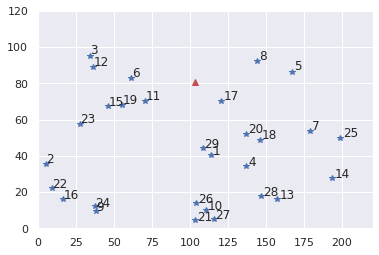

In [6]:
#visualise
plot_patient_coordinates(x_coords, y_coords)

## Approaches to 'solving' the CVRP

* Formulation as a **Mixed Integer Programme** (MIP) and use of a optimisation solver
* Heuristic solution.  E.g. using Iterated Local Search.

## Mixed Integer Programme (MIP) formulation

* The advantage of a mathematical forumulation of the problem is that we can use a modern solver like **Gurobi**.
* Gurobi is extremely powerful.  The downside is that a commerical tool and the source code is closed (but free to use in research).

$n$ is the number of patients

$N$ is the set of patients $\{1, 2, ..., n\}$

$V$ is the set of verticies (nodes) to visit. $V=\{0\}\cup N$

$A$ is the set of arcs (links) $A = \left\{ \left(i,j\right)  \in V^2 : i\neq j\right\}$

$c_{ij}$ is cost of travel over arc $(i,j)\in A$

$Q$ is the vehicle capacity (for ambulances this is an integer)

$q_i$ is the load represented by a patient (in our problem this always 1)



\begin{equation}
\begin{aligned}
       \text{min} &  \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} \\
       \text{s.t.} & \sum_{i=1}^{n} x_{ij} = 1, & & j \in N, j \neq i \\
       &   \sum_{j=1}^{n} x_{ij} = 1, & & i \in N, i \neq j \\
       &  \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
       &  q_i \leq u_i \leq Q && i \in N \\
       &  x_{ij} \in \{0,1\} && i,j \in A
\end{aligned}
\end{equation}




## Model Execution

> Warning runtime can increase significantly for large problems!

Experiments:

* `N_PATIENTS = 10`
* `N_PATIENTS = 30`

In [24]:
#model parameters
N_PATIENTS = 10
VEHICLE_CAPACITY = 4
TIME_LIMIT = -1
SEED = 101

#create a problem instance
instance = problem_instance(N_PATIENTS, VEHICLE_CAPACITY, random_state=SEED)

#create an instance of a gurobi optimisation model
model, x, u = optimisation_model(instance)

#limit run time?
if TIME_LIMIT > -1:
    model.Params.TimeLimit = TIME_LIMIT  

#execute the optimisation procedure
model.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0x0169e2a8
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve added 205 rows and 25 columns
Presolve time: 0.00s
Presolved: 245 rows, 145 columns, 1350 nonzeros
Variable types: 55 continuous, 90 integer (90 binary)

Root relaxation: objective 3.695996e+02, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  369.59959    0   22          -  369.59959      -     -    0s
H    0     0                    1180.9647963  369.59959  68.7%     -    0s
H    0     0                    1015.6786489  369.59959  63.6%     -  

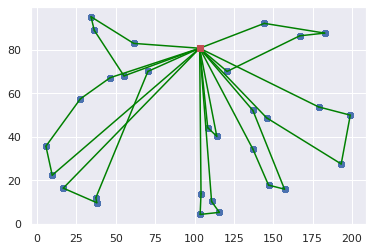

In [22]:
#show the routes
plot_solution(x, instance)

## Pre-saved results for 30 patients

* best in 2.5 hours = 1426.55594 with 39% optimality gap. (lower bound = 869)
*it took 930s (15.5 minutes) to reach this solution.

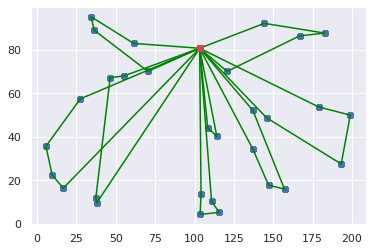

In [23]:
active_arcs = pd.read_csv('best_solution_30_patients.csv').to_numpy()

xc = instance['x_coords']
yc = instance['y_coords']

for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')